## Independent Analysis 2 - Srinivas (handle: thewickedaxe)
** PLEASE SCROLL TO THE BOTTOM OF THE NOTEBOOK TO FIND THE QUESTIONS AND THEIR ANSWERS AND OTHER GENERAL FINDINGS**

### Initial Data Cleaning

In [14]:
# Standard
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Dimensionality reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import manifold, datasets
from sklearn import preprocessing
from itertools import cycle

# Plotting tools and classifiers
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut


# Let's read the data in and clean it

def get_NaNs(df):
    columns = list(df.columns.get_values()) 
    row_metrics = df.isnull().sum(axis=1)
    rows_with_na = []
    for i, x in enumerate(row_metrics):
        if x > 0: rows_with_na.append(i)
    return rows_with_na

def remove_NaNs(df):
    rows_with_na = get_NaNs(df)
    cleansed_df = df.drop(df.index[rows_with_na], inplace=False)     
    return cleansed_df

initial_data = pd.DataFrame.from_csv('Data_Adults_1_reduced_2.csv')
cleansed_df = remove_NaNs(initial_data)

# Let's also get rid of nominal data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = cleansed_df.select_dtypes(include=numerics)
print X.shape

(6785, 10)


The change from last week was that we also threw out 

we've now dropped the last of the discrete numerical inexplicable data, and removed children from the mix

### Extracting the samples we are interested in

In [15]:
# Let's extract ADHd and Bipolar patients (mutually exclusive)

ADHD = X.loc[X['ADHD'] == 1]
ADHD = ADHD.loc[ADHD['Bipolar'] == 0]

BP = X.loc[X['Bipolar'] == 1]
BP = BP.loc[BP['ADHD'] == 0]

print ADHD.shape
print BP.shape

# Keeping a backup of the data frame object because numpy arrays don't play well with certain scikit functions
ADHD = pd.DataFrame(ADHD.drop(['Patient_ID', 'Age', 'ADHD', 'Bipolar'], axis = 1, inplace = False))
BP = pd.DataFrame(BP.drop(['Patient_ID', 'Age', 'ADHD', 'Bipolar'], axis = 1, inplace = False))

print ADHD.shape
print BP.shape

(2370, 10)
(793, 10)
(2370, 6)
(793, 6)


### Clustering and other grouping experiments

In [16]:
ADHD_clust = pd.DataFrame(ADHD)
BP_clust = pd.DataFrame(BP)

# This is a consequence of how we dropped columns, I apologize for the hacky code 
data = pd.concat([ADHD_clust, BP_clust])

#### K-Means clustering

In [17]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data.get_values())
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(cluster_centers))
print data.shape

Estimated number of clusters: 2
(3163, 6)


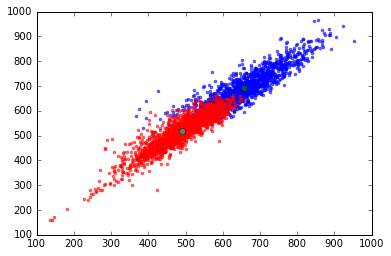

In [18]:
for label in [0, 1]:
    ds = data.get_values()[np.where(labels == label)]    
    plt.plot(ds[:,0], ds[:,1], '.',alpha=0.6)    
    lines = plt.plot(cluster_centers[label,0], cluster_centers[label,1], 'o', alpha=0.7)

### Classification Experiments

Let's experiment with a bunch of classifiers

In [19]:
ADHD_iso = pd.DataFrame(ADHD_clust)
BP_iso = pd.DataFrame(BP_clust)

In [20]:
BP_iso['ADHD-Bipolar'] = 0
ADHD_iso['ADHD-Bipolar'] = 1
print BP_iso.columns
data = pd.DataFrame(pd.concat([ADHD_iso, BP_iso]))
class_labels = data['ADHD-Bipolar']
data = data.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
print data.shape
data_backup = data.copy(deep = True)
data = data.get_values()

Index([u'Concentration_Caudate_L', u'Concentration_Caudate_R',
       u'Concentration_Pallidum_L', u'Concentration_Pallidum_R',
       u'Concentration_Putamen_L', u'Concentration_Putamen_R',
       u'ADHD-Bipolar'],
      dtype='object')
(3163, 6)


In [21]:
# Based on instructor suggestion i'm going to run a PCA to examine dimensionality reduction
pca = PCA(n_components = 2, whiten = "True").fit(data)
data = pca.transform(data)
print sum(pca.explained_variance_ratio_)

0.976132696711


In [22]:
# Leave one Out cross validation
def leave_one_out(classifier, values, labels):
    leave_one_out_validator = LeaveOneOut(len(values))
    classifier_metrics = cross_validation.cross_val_score(classifier, values, labels, cv=leave_one_out_validator)
    accuracy = classifier_metrics.mean()
    deviation = classifier_metrics.std()
    return accuracy, deviation

In [23]:
svc = SVC(gamma = 2, C = 1)
bc = BaggingClassifier(n_estimators = 22)
gb = GradientBoostingClassifier()
dt = DecisionTreeClassifier(max_depth = 22) 
qda = QDA()
gnb = GaussianNB()
vc = VotingClassifier(estimators=[('gb', gb), ('bc', bc), ('gnb', gnb)],voting='hard')
classifier_accuracy_list = []
classifiers = [(gnb, "Gaussian NB"), (qda, "QDA"), (svc, "SVM"), (bc, "Bagging Classifier"),
               (vc, "Voting Classifier"), (dt, "Decision Trees")]
for classifier, name in classifiers:
    accuracy, deviation = leave_one_out(classifier, data, class_labels)
    print '%s accuracy is %0.4f (+/- %0.3f)' % (name, accuracy, deviation)
    classifier_accuracy_list.append((name, accuracy))

Gaussian NB accuracy is 0.7468 (+/- 0.435)
QDA accuracy is 0.7458 (+/- 0.435)
SVM accuracy is 0.7480 (+/- 0.434)
Bagging Classifier accuracy is 0.6709 (+/- 0.470)
Voting Classifier accuracy is 0.7452 (+/- 0.436)
Decision Trees accuracy is 0.6576 (+/- 0.475)


given the number of people who have ADHD and Bipolar disorder the chance line would be at around 0.6. The classifiers fall between 0.7 and 0.75 which makes them just barely better than chance. This is still an improvement over last time.

###  Running Multivariate regression

#### On data pre dimensionality reduction

In [13]:
X = data_backup
y = class_labels

X1 = sm.add_constant(X)
est = sm.OLS(y, X1).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ADHD-Bipolar   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.397
Date:                Mon, 11 Apr 2016   Prob (F-statistic):            0.00242
Time:                        21:22:54   Log-Likelihood:                -1833.5
No. Observations:                3163   AIC:                             3681.
Df Residuals:                    3156   BIC:                             3723.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                        0.8185      0.043     18.957      0.000         0.734     0.903
Concentration_Caudate_L      0.0003      0.000      1.179      0.239        -0.000     0.001
Concentration_Caudate_R  -4.293e-06      0.000     -0.014      0.989        -0.001     0.001
Concentration_Pallidum_L    -0.0003      0.000     -1.103      0.270        -0.001     0.000
Concentration_Pallidum_R    -0.0004      0.000     -1.772      0.076        -0.001  4.43e-05
Concentration_Putamen_L     -0.0003      0.000     -0.862      0.389        -0.001     0.000
Concentration_Putamen_R      0.0007      0.000      1.994      0.046      1.13e-05     0.001
==============================================================================
Omnibus:                      597.640   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              742.489
Skew:                          -1.139   Prob(JB):                    5.90e-162
Kurtosis:                       2.331   Cond. No.                     9.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### On data post dimensionality reduction

In [24]:
X = data
y = class_labels

X1 = sm.add_constant(X)
est = sm.OLS(y, X1).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ADHD-Bipolar   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.228
Date:                Mon, 11 Apr 2016   Prob (F-statistic):           0.000738
Time:                        22:34:29   Log-Likelihood:                -1836.5
No. Observations:                3163   AIC:                             3679.
Df Residuals:                    3160   BIC:                             3697.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.7493      0.008     97.403      0.000         0.734     0.764
x1            -0.0192      0.008     -2.496      0.013        -0.034    -0.004
x2            -0.0221      0.008     -2.868      0.004        -0.037    -0.007
==============================================================================
Omnibus:                      600.386   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              747.529
Skew:                          -1.143   Prob(JB):                    4.74e-163
Kurtosis:                       2.331   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Questions and Answers

##### 1) Literature Investigation
The data csv is a bit different this time. We threw out all the baseline values and only retained concentration values for the Putamen, Claudate and Pallidum, in addition to all regions marked "frontal". The rationale behind this a lot of the literature online says that the shape and size of the basal ganglia and the frontal lobe is affected by both ADHD and Bipolar disorder.

Given this extreme reduction in input dimensionality I expected the classifiers to be very successful.


##### 2) Mix and Match data and examine classifier performance
We tried mixing and matching various permutations and combinations of the concentration columns and the classifiers still were no better than chance.

This led me to question either the integrity of the data or if whether basal ganglia blood flow differences are captured in spect data. 


##### 3) Confirmatory Analysis
So we carried out a small experiment. Given the rCBF values for the basal ganglia and a label vector labelling patients as either suffering from ADHD or Bipolar disorder is there any clustering evident? Our ensemble classifers working on this dataset

##### 4) Running a Multivariate regression model to see if any single field or set of fields stand out as indicators of ADHD or Bipolar 
No field stood out, further confirming our supposition that the clinically established facts that the basal ganglia is affected by bipolar disorder and ADHD do not manifest in the rCBF reading extrapolated from SPECT image scans

#### Findings
1. The classifiers are still no better than chance even after eliminating all other noise
2. No clustering is really apparent